# Thesis Data Analysis

In [1]:
# read .csv
from svglib.svglib import svg2rlg

# computation & data structures
import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, abs, mean
import itertools
import pandas as pd
from typing import Callable, Tuple
import glob

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.graphics import renderPDF
import os
import shutil
from dataclasses import dataclass, field

import time
from matplotlib.animation import FuncAnimation
from IPython import display

## Map Output Analysis

This cell handles the GIS output. Most of the attributes have already been calculated, so the main purpose of this code is to examine subsets of the data (center points, sample locations, distances) and evaluate each inflation center by a few different criteria (fraction of data explainable, fraction explainable within certain tilt constraints, etc.).

In [2]:
MARS_EQ_RADIUS = 3396.2  # km


def dist(lat, lon, latC, lonC):
    '''distance between pts 1 and 2'''
    lat1 = rad(lat)
    lon1 = rad(lon)
    lat2 = rad(latC)
    lon2 = rad(lonC)
    rads = arccos(
        cos(lat1) * cos(lat2)
        * cos(lon2 - lon1)
        + sin(lat1) * sin(lat2)
    )
    return rads * MARS_EQ_RADIUS


def bearing(lat, lon, latC, lonC):
    '''angle from pt 1 AWAY from pt 2'''
    lat1 = rad(lat)
    lon1 = rad(lon)
    lat2 = rad(latC)
    lon2 = rad(lonC)
    y = sin(lon2 - lon1) * cos(lat2)
    x = cos(lat1) * sin(lat2) \
        - sin(lat1) * cos(lat2) * cos(lon2 - lon1)
    return (180 + deg(arctan2(y, x))) % 360


def beta(az, bearing):
    '''angle difference ranging from -180 to +180'''
    return ((az - bearing + 180) % 360) - 180


def sl1(beta1, beta2, sl2):
    beta1 = rad(beta1)
    beta2 = rad(beta2)
    sl2 = rad(sl2)
    arg = sin(beta2) * sin(sl2) / sin(beta1)
    if arg < 0 or arg > 1:  # not possible
        return np.nan
    else:
        sl1 = arcsin(arg)
        return deg(sl1)


def proj(beta, sl):
    beta = rad(beta)
    sl = rad(sl)
    proj = arctan(tan(beta) * cos(beta))
    return deg(proj)


def tilt(beta1, sl1, beta2, sl2):
    return proj(beta2, sl2) - proj(beta1, sl1)

In [3]:
# location to read .csv files
map_path = "../GEOL192-GIS/data/"


centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index(['sID', 'FEATURE'])

cIDs = tuple(centers.index)
sIDs = tuple(index[0] for index in samples.index)

This cell defines an object to organize the data from a single .csv file (corresponding to a single candidate center point).

In [4]:
@dataclass
class Center:
    cID: int

    def __post_init__(self):
        self.data = samples.copy()

        # this of course only works for unique self.cIDs
        self.latC = centers.loc[self.cID, 'LAT']
        self.lonC = centers.loc[self.cID, 'LON']
        self.calculate()

    def plot(self, name: str = None):  # type: ignore
        fig = plt.figure(figsize=(8, 5), dpi=600)

        sns.scatterplot(data=self.data, x='DIST', y='TILT')

        plt.title(f"Tilt from Center {self.cID}")
        plt.xlabel("Distance (km)")
        plt.ylabel("Tilt (deg)")
        plt.legend()

        # save plot with name if passed as argument
        if name is not None:
            fig.savefig("plot.svg")
            renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
            os.remove("plot.svg")

    def calculate(self):

        self.data['DIST'] = self.data.apply(
            lambda row: dist(
                lat=row['LAT'], lon=row['LON'],
                latC=self.latC, lonC=self.lonC
            ),
            axis=1
        )

        self.data['BEARING'] = self.data.apply(
            lambda row: bearing(
                lat=row['LAT'], lon=row['LON'],
                latC=self.latC, lonC=self.lonC
            ),
            axis=1
        )

        self.data['BETA1'] = self.data.apply(
            lambda row: beta(
                az=row['AZ1'], bearing=row['BEARING']
            ),
            axis=1
        )

        self.data['BETA2'] = self.data.apply(
            lambda row: beta(
                az=row['AZ2'], bearing=row['BEARING']
            ),
            axis=1
        )

        self.data['SL1'] = self.data.apply(
            lambda row: sl1(
                beta1=row['BETA1'],
                beta2=row['BETA2'], sl2=row['SL2']
            ),
            axis=1
        )

        self.data['TILT'] = self.data.apply(
            lambda row: tilt(
                beta1=row['BETA1'], sl1=row['SL1'],
                beta2=row['BETA2'], sl2=row['SL2']
            ),
            axis=1
        )

In [5]:
# about .05 seconds (40 s total)
centers_calc = [Center(cID) for cID in cIDs]

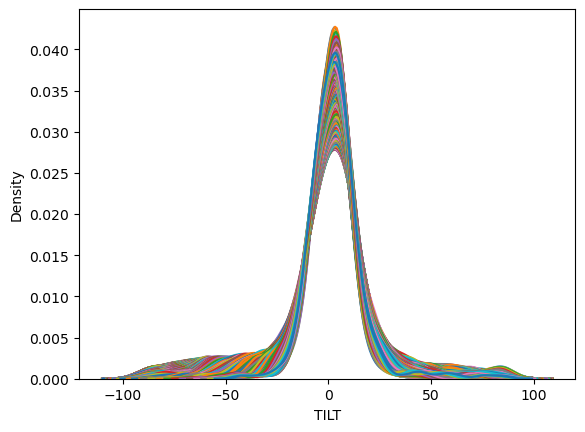

In [6]:
for center in centers_calc:
    sns.kdeplot(x=center.data['TILT'])

## Populations (Subsets)

In [8]:
@dataclass
class Population:
    feature: tuple = ('flow', 'channel')
    name: str = ''
    sIDs: tuple = sIDs  # type: ignore


pops = [
    Population(),
    Population(('flow',)),
    Population(('channel',)),
    # these are wrong, will have to look for point IDs or go back to get linear feature Ids to inherit into samples.
    # Population(('flow',), 'SE', (49, 60, 61, 62, 63, 64, 85, 86, 87))
]

## Criteria

In [9]:
def summit_score(center: Center, pop: Population):
    df = center.data
    subset_beta1 = df.loc[(pop.sIDs, pop.feature), 'BETA1']
    return mean(abs(subset_beta1))


@dataclass
class Criterion:
    func: Callable
    name: str


criteria = [Criterion(summit_score, 'summit_score')]  # needs to be an iterable


def evaluate(center: Center, pop: Population, crit: Criterion) -> float:
    return crit.func(center, pop)

In [10]:
full_dict = {}
score_name_list = []

for pop in pops:
    for crit in criteria:
        name = f'{pop.feature}_{pop.name}_{crit.name}'
        name = name.replace("__", "_")
        name = name.replace("(", "")
        name = name.replace(")", "")
        name = name.replace(",", "")
        name = name.replace("'", "")
        name = name.replace("flow channel_", "")
        score_name_list.append(name)

for center in centers_calc:
    cID = center.cID
    center_list = []
    for pop in pops:
        for crit in criteria:
            center_list.append(evaluate(center, pop, crit))
    full_dict[center.cID] = center_list

In [11]:
centers_eval = pd.concat((centers, pd.DataFrame(full_dict).transpose().set_axis(score_name_list, axis=1)), axis=1)

centers_eval = centers_eval.loc[:,~centers_eval.columns.duplicated()] # type: ignore

## Model Output Analysis

Then, I define functions for reading the starting positions and displacements (radial and vertical components) of mesh vertices as expressed in the COMSOL files.

In [12]:
model_data_location = "../GEOL192-Model/data/"

topo = np.genfromtxt(f'{model_data_location}z1.csv', delimiter=",")


def model_pos1_from_csv(name: str):
    r = np.genfromtxt(model_data_location + "r_" + name, delimiter=",")[:, 0]
    z = np.interp(r, *topo.T, right=0)
    return np.array([r, z]).T


def model_disp_from_csv(name: str):
    r = np.genfromtxt(f'{model_data_location}r_{name}', delimiter=",")[:, 1]
    z = np.genfromtxt(f'{model_data_location}z_{name}', delimiter=",")[:, 1]
    return np.array([r, z]).T

I define physical constants used in the model here:

In [13]:
# constants in SI units
SHEAR_MODULUS = 2.4e10
ROCK_DENSITY = 2700
MAGMA_DENSITY = 2700
MARS_GRAVITY = 3.72
PLOT_WIDTH = 200_000


I include functions for displacement and angular tilt from an analytical solution which assumes a elastic half-space inflated by a spherical reservoir, for comparison as appropriate.

In [14]:
@dataclass
class MogiModel:
    dP: float
    radius: float
    DtC: float
    r1: np.array  # type: ignore

    def disp(self) -> np.array:  # type: ignore
        common = 3 * self.radius**3 * self.dP / \
            (4 * SHEAR_MODULUS * (self.DtC**2 + self.r1**2)**1.5)
        rdisp = common * self.r1
        zdisp = common * self.DtC
        return np.array(rdisp, zdisp)

    def tilt(self) -> np.array:  # type: ignore
        a = 3 * self.radius**3 * self.dP / (4 * SHEAR_MODULUS)
        num = 3 * a * self.DtC * self.r1
        denom = (self.DtC**2 + self.r1**2)**2.5 + \
            a * self.DtC**2 - 2 * a * self.r1**2
        return deg(arctan2(num, denom))

Then I define classes for displaced vertices and surface elements (the latter defined by a consecutive pair of the former). These classes are primarily used to handle the radial tilt calculation.

In [15]:
@dataclass
class Vertex:
    pos1: Tuple[float, float]
    disp: Tuple[float, float]

    def __post_init__(self):
        self.pos2 = self.pos1 + self.disp


@dataclass
class Element:
    proximal: Vertex  # (A in text)
    distal: Vertex  # (B in text)

    def __post_init__(self):
        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = self.distal.pos1 - self.proximal.pos1  # type: ignore
        self.shape2 = self.distal.pos2 - self.proximal.pos2  # type: ignore

        # mean position of initial and displaced segments
        self.pos1 = (self.distal.pos1 + self.proximal.pos1) / 2  # type: ignore
        self.pos2 = (self.distal.pos2 + self.proximal.pos2) / 2  # type: ignore

        # radial distances for plotting
        self.r1_km = self.pos1[0] / 1000
        self.r2_km = self.pos2[0] / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = deg(arctan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = deg(arctan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1


Finally, a model class is initialized by a combination of parameters (geometry, overpressure) which reads the relevant .csv files, builds the vertices and elements, and converts the element attributes (position, displacement, tilt) into lists for plotting or further analysis.

In [24]:
class Model:
    def __init__(self, params: dict):

        self.params = params

        self.dP = params['pmult'] * params['DtT'] * ROCK_DENSITY * MARS_GRAVITY

        filename = f"DtT_{params['DtT']}_resr_{params['resr']}_pmult_{params['pmult']}_gmult_{int(params['grav'])}_zmult_{int(params['topo'])}_resaspect_{params['aspect']}.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # subtract out gravitational component (with no overpressure)
        if params['grav']:
            filename_p0 = filename.replace(
                f"pmult_{params['pmult']}", "pmult_0")
            self.disp -= model_disp_from_csv(filename_p0)

        # make z1 flat for flat model
        if not params['topo']:
            self.pos1[1] = np.zeros(len(self.pos1[1]))

        # build vertices from pos1 and disp if pos1 within defined length
        self.num_vertices = next(i for i, val in enumerate(
            self.pos1) if val[0] > PLOT_WIDTH)
        self.vertices = [Vertex(self.pos1[i], self.disp[i])
                         for i in range(self.num_vertices)]

        # build elements from consecutive vertex pairs
        self.vertex_pairs = zip(self.vertices[:-1], self.vertices[1:])
        self.elements = [Element(*pair) for pair in self.vertex_pairs]

        # put element attributes into dict of lists
        self.attributes = pd.DataFrame(
            [vars(element) for element in self.elements]).to_dict("list")

        if params['aspect'] == 1:
            self.mogi_tilt = MogiModel(
                dP=self.dP,
                radius=params['resr'],
                DtC=params['DtT'] + params['resr'],
                r1=self.attributes['r1_km']).tilt()

# Model Output Analysis

I define the model parameter combinations used in COMSOL and build a Model class (defined above) from each geometry. Any subset of geometries can be used by removing elements from the parameter sets.

In [35]:
# parameter sweep in SI units (to match csv output from COMSOL)
class ParamSweep:
    def __init__(self, params: dict):

        # define constant parameters for labelling once in title
        self.constants = {key: val[0]
                          for key, val in params.items() if len(val) == 1}

        # define variable parameters for labelling individually
        self.variables = [key for key, val in params.items() if len(val) > 1]

        self.models = [Model(dict(zip(params, item)))
                       for item in itertools.product(*params.values())]

    def plot(self, name: str = None):  # type: ignore
        fig = plt.figure(figsize=(8, 5), dpi=600)

        for model in self.models:
            label = '{}'.format({param: model.params[param] for param in self.variables})
            label = label.replace("{", "")
            label = label.replace("}", "")
            label = label.replace("'", "")
            sns.lineplot(data=model.attributes, y="tilt", x="r2_km", label=label)

        title = f'{self.constants}'
        title = title.replace("{", "")
        title = title.replace("}", "")
        title = title.replace("'", "")
        plt.title(f"Radial Tilt: {title}")
        plt.xlabel("Distance (km)")
        plt.ylabel("Tilt (deg)")
        plt.legend(loc="upper right")

        # save plot with name if passed as argument
        if name is not None:
            fig.savefig("plot.svg")
            renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
            os.remove("plot.svg")


test_sweep = ParamSweep({
    "DtT": [10_000, 12_000],  # 10_000
    "resr": [30_000],
    "aspect": [.5],
    "pmult": [0.6],
    "grav": [False],  # 0, 1
    "topo": [True]  # 0, 1
})

full_sweep = ParamSweep({
    "DtT": [14_000],  # 10_000
    "resr": [30_000],
    "aspect": [.5],
    "pmult": [0.2, 0.6],
    "grav": [False],
    "topo": [True]
})

# Plotting

Finally, I plot numerical model outputs:

In [ ]:
test_sweep.plot()
centers_calc[1].plot()

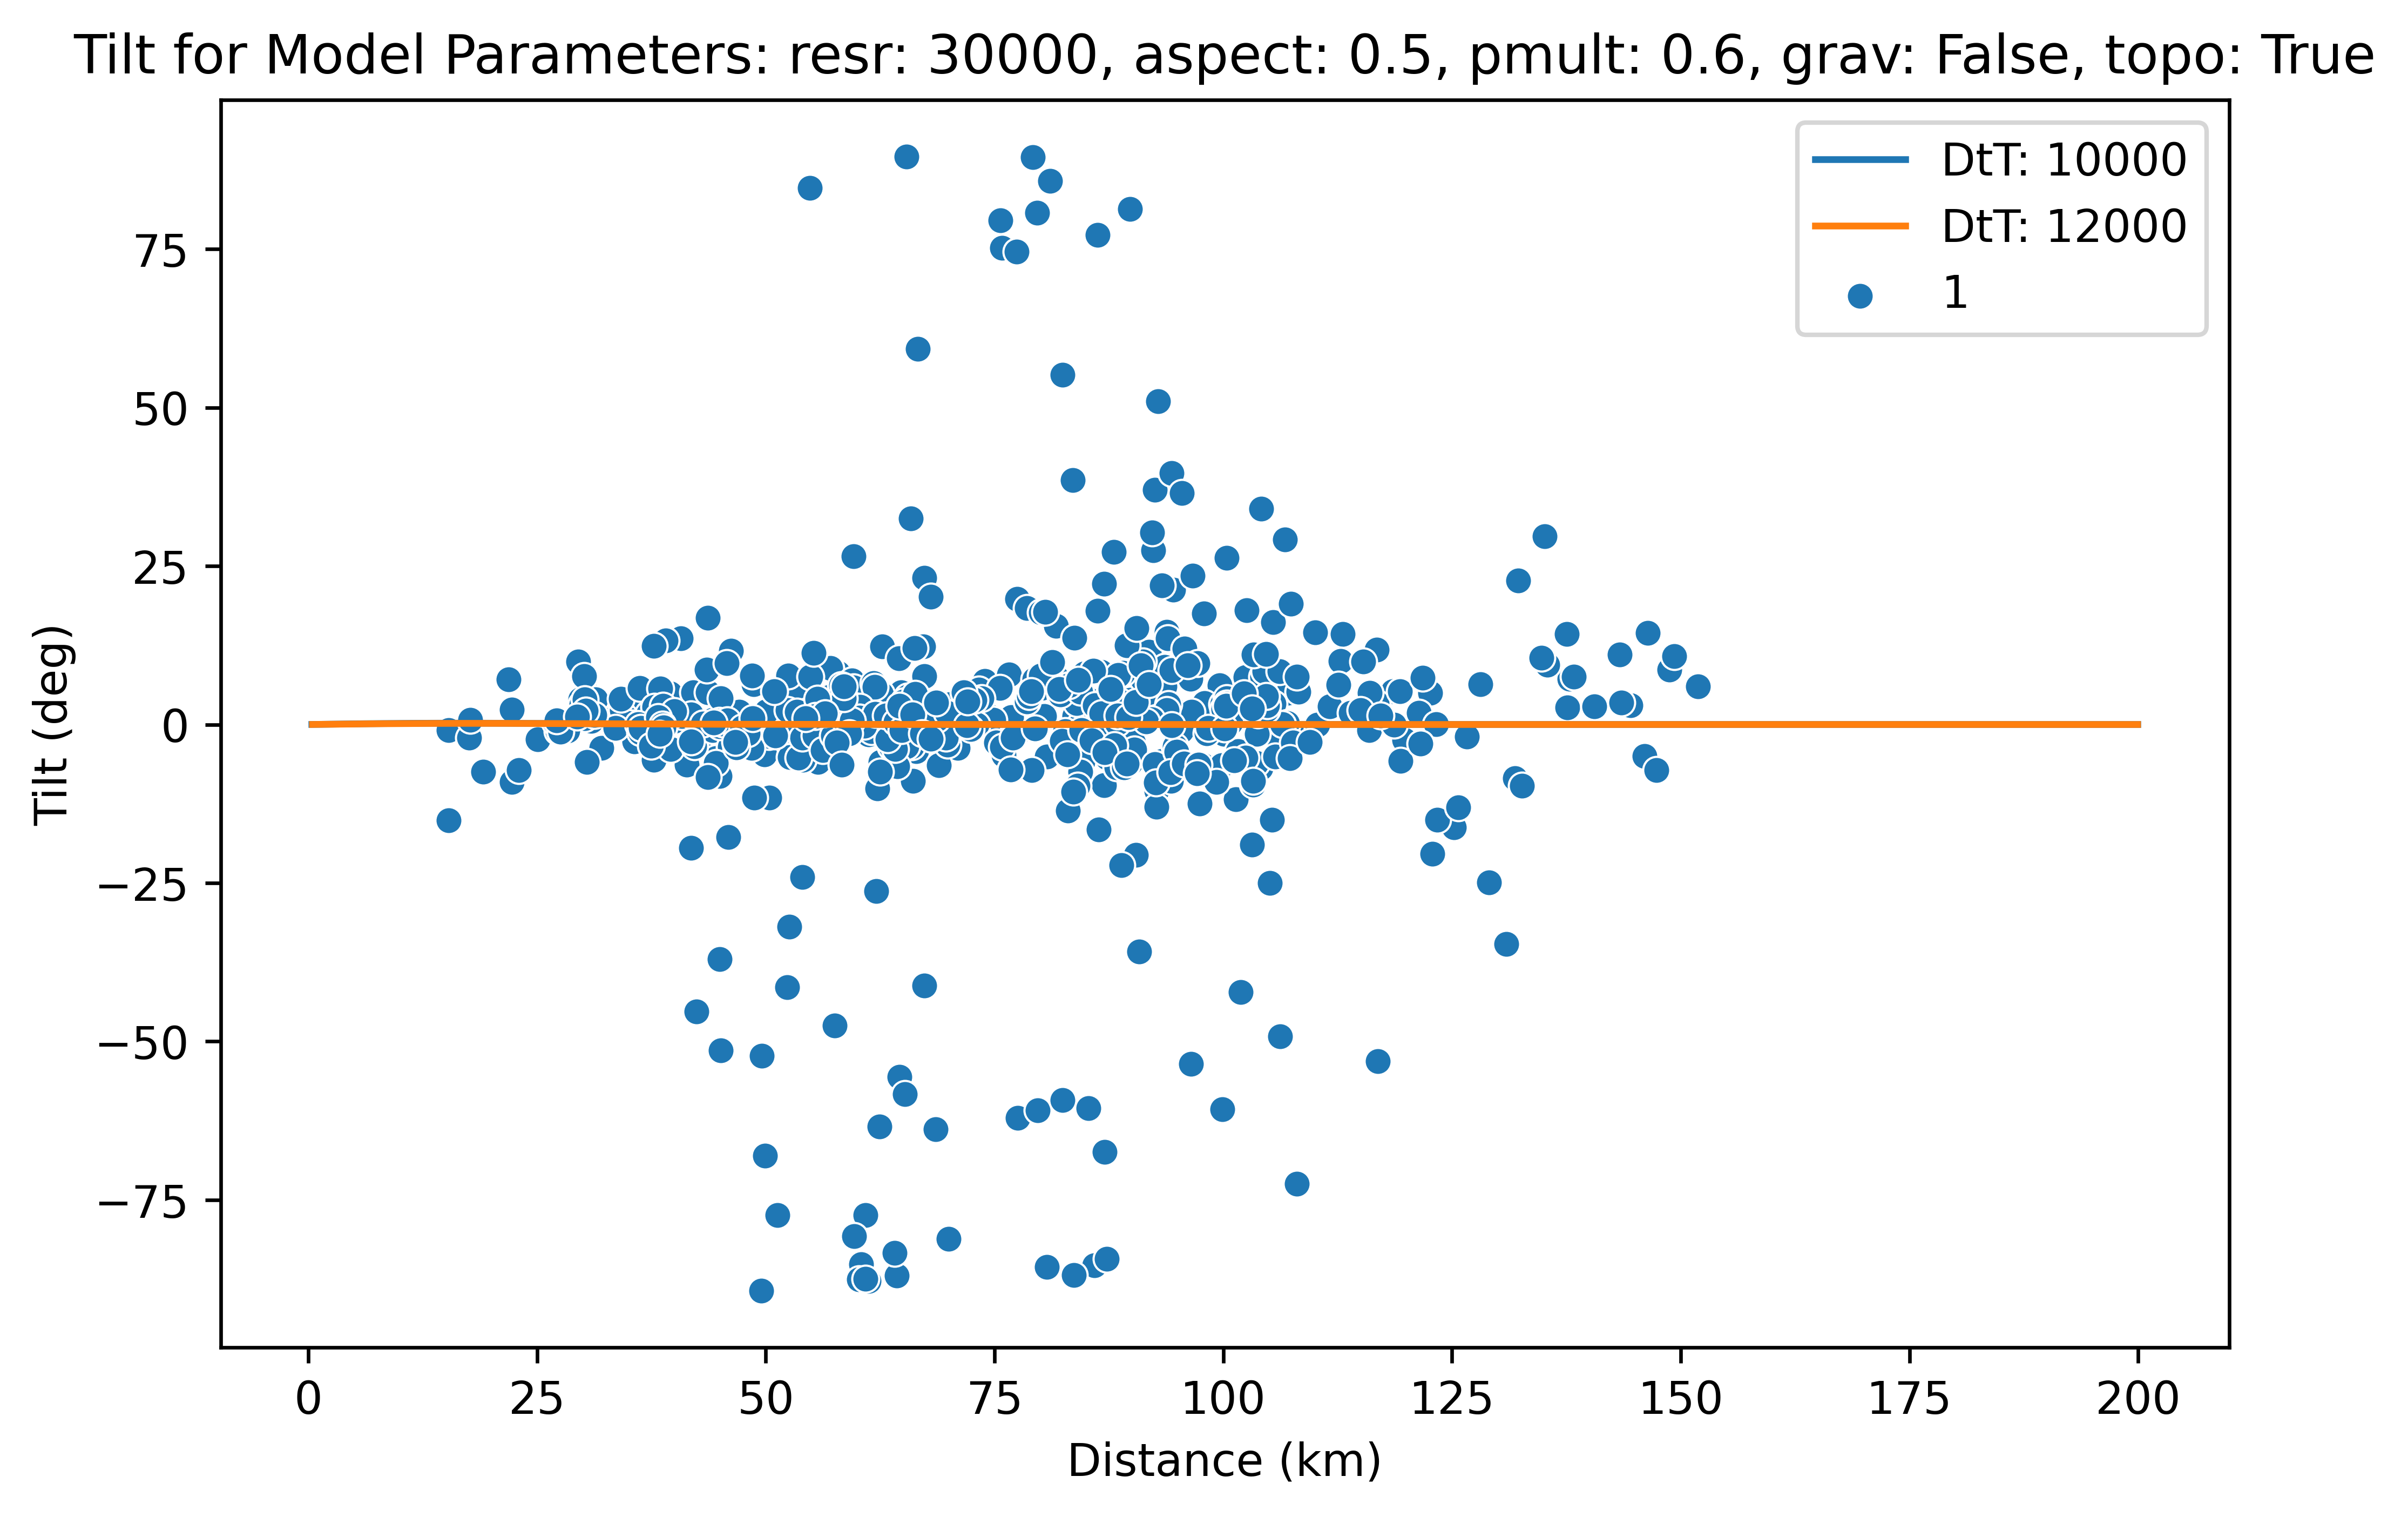

In [40]:
def combined_plot(sweep: ParamSweep, centers: list[Center], name: str = None): # type: ignore
    fig = plt.figure(figsize=(8, 5), dpi=600)

    for model in sweep.models:
        label = '{}'.format({param: model.params[param] for param in sweep.variables})
        label = label.replace("{", "")
        label = label.replace("}", "")
        label = label.replace("'", "")
        sns.lineplot(data=model.attributes, y="tilt", x="r2_km", label=label)

    for center in centers:
        sns.scatterplot(data=center.data, x='DIST', y='TILT', label=center.cID)

    model_title = f'{sweep.constants}'
    model_title = model_title.replace("{", "")
    model_title = model_title.replace("}", "")
    model_title = model_title.replace("'", "")
    plt.title(f"Radial Tilt: {model_title}")

    plt.title(f"Tilt for Model Parameters: {model_title}")
    plt.xlabel("Distance (km)")
    plt.ylabel("Tilt (deg)")
    plt.legend()

    # save plot with name if passed as argument
    if name is not None:
        fig.savefig("plot.svg")
        renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
        os.remove("plot.svg")

combined_plot(test_sweep, [centers_calc[0]])